In [1]:
import numpy as np
import tensorflow as tf
import time
import math

In [2]:
voxel_train = np.load('voxel_train.npy')
gt_train = np.load('gt_train.npy')

voxel_test = voxel_train[-1000:, :]
gt_test = gt_train[-1000:,:]
voxel_train = voxel_train[:-1000,:]
gt_train = gt_train[:-1000,:]

In [3]:
#Define Loss functions

arr=np.logspace(math.log10(10.0), math.log10(10.), num=1, endpoint=True, base=10.0) # num = number of output

arr=np.tile(arr, (10, 1)) #(x,y) x = batch size

arr_tf=tf.constant(arr.astype('float32'), dtype=tf.float32)

#Implementation of the Wasserstein Distance
def wasserstein_distance(y_actual,y_pred):

    #np.abs(np.cumsum(gt_distributions[40,:]-dist_array[40,:])      
    abs_cdf_difference=tf.math.abs(tf.math.cumsum(y_actual-y_pred,axis=1))

    return tf.reduce_mean(0.5*tf.reduce_sum(tf.math.multiply(-arr_tf[:,:-1]+arr_tf[:,1:],abs_cdf_difference[:,:-1]+abs_cdf_difference[:,1:]),axis=1))

#Combination loss function used in MIML
def MSE_wasserstein_combo(y_actual,y_pred):

    wass_loss=wasserstein_distance(y_actual,y_pred)
    MSE= tf.math.reduce_mean(tf.reduce_mean(tf.math.squared_difference(y_pred, y_actual),axis=1))

    return wass_loss+MSE

In [5]:
#Define the network structure
inputs = tf.keras.Input(shape=(6,)) #number of inputs
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(inputs)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x) # no. of outputs
#outputs=tf.keras.layers.Dense(1, activation=tf.keras.activations.relu, kernel_initializer='normal',bias_initializer=tf.keras.initializers.Constant(0.1))(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [6]:
#Define optimizer and train the network

#To save the model for each epoch, uncomment the checkpoint_callback below
# checkpoint_callback=tf.keras.callbacks.ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True mode='auto', save_freq='epoch')

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss=MSE_wasserstein_combo, metrics=['mse',wasserstein_distance])

start=time.time()

history = model.fit(voxel_train, gt_train,epochs=10, batch_size=10, validation_split=0.1)  # starts training

# Original parameters
# model.fit(signals_train, distributions_train,epochs=30, batch_size=2000, validation_data=(signals_valid,distributions_valid),callbacks=[checkpoint_callback])  # starts training

end=time.time()
print('Time Elapsed:%i seconds'%(end-start))

Epoch 1/10
8910/8910 [==============================] - 42s 5ms/step - loss: 0.0049 - mse: 0.0049 - wasserstein_distance: 0.0000e+00 - val_loss: 1.8718e-04 - val_mse: 1.8718e-04 - val_wasserstein_distance: 0.0000e+00
Epoch 2/10
8910/8910 [==============================] - 42s 5ms/step - loss: 9.1893e-04 - mse: 9.1893e-04 - wasserstein_distance: 0.0000e+00 - val_loss: 1.0153e-04 - val_mse: 1.0153e-04 - val_wasserstein_distance: 0.0000e+00
Epoch 3/10
8910/8910 [==============================] - 40s 4ms/step - loss: 3.2367e-04 - mse: 3.2367e-04 - wasserstein_distance: 0.0000e+00 - val_loss: 9.7390e-05 - val_mse: 9.7390e-05 - val_wasserstein_distance: 0.0000e+00
Epoch 4/10
8910/8910 [==============================] - 39s 4ms/step - loss: 0.0024 - mse: 0.0024 - wasserstein_distance: 0.0000e+00 - val_loss: 1.3381e-04 - val_mse: 1.3381e-04 - val_wasserstein_distance: 0.0000e+00
Epoch 5/10
8910/8910 [==============================] - 41s 5ms/step - loss: 4.8074e-04 - mse: 4.8074e-04 - wasserst

dict_keys(['loss', 'mse', 'wasserstein_distance', 'val_loss', 'val_mse', 'val_wasserstein_distance'])


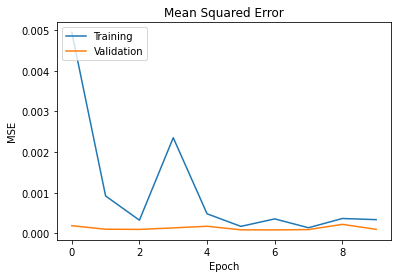

In [7]:
#print(model.summary())
print(history.history.keys())

import matplotlib.pyplot as plt
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [8]:
results = model.evaluate(voxel_test, gt_test, batch_size=10)
print("test loss, test mse:", results)

100/100 [==============================] - 0s 2ms/step - loss: 9.4768e-05 - mse: 9.4768e-05 - wasserstein_distance: 0.0000e+00
test loss, test mse: [9.47679509408772e-05, 9.47679509408772e-05, 0.0]


In [9]:
voxel_test = voxel_test[0:10,:]
gt_predict = model.predict(voxel_test)
# show the inputs and predicted outputs
for i in range(len(voxel_test)):
	print("Actual T2=%s, Predicted=%s" % (gt_test[i], gt_predict[i]))

Actual T2=[0.08], Predicted=[0.09083577]
Actual T2=[0.1], Predicted=[0.09105797]
Actual T2=[0.1], Predicted=[0.09456002]
Actual T2=[0.1], Predicted=[0.09513694]
Actual T2=[0.08], Predicted=[0.08872977]
Actual T2=[0.08], Predicted=[0.09191944]
Actual T2=[0.08], Predicted=[0.09005172]
Actual T2=[0.08], Predicted=[0.09426831]
Actual T2=[0.08], Predicted=[0.09091296]
Actual T2=[0.1], Predicted=[0.09308352]


In [11]:
model.save('voxel_regression')

INFO:tensorflow:Assets written to: voxel_regression\assets
